In [58]:
import os
if not os.path.isfile("NOPIP"):
    print("Running pip installs. Create a file called 'NOPIP' to disable.")
    %pip install carbon-simulator
    %pip install ipywidgets

In [59]:
from carbon.helpers.stdimports import *
from carbon.helpers import j, strategy, pdread, pdcols, fsave, listdir, Params, PathInterpolation as PI
from carbon.helpers import require_version
from carbon.helpers.widgets import CheckboxManager, DropdownManager, PcSliderManager
try:
    from simulation import run_sim, plot_sim, SIM_DEFAULT_PARAMS, COLORS, __VERSION__ as simversion
    from carbon.helpers.simulation import __VERSION__ as csimversion
    print(f"Using local copy of the simulation library [v{simversion}; Carbon: v{csimversion}]")
except:
    from carbon.helpers.simulation import run_sim, plot_sim, SIM_DEFAULT_PARAMS, COLORS, __VERSION__ as simversion
    print(f"Using simulation library in Carbon [v{simversion}]")
import pickle
import datetime 

plt.rcParams['figure.figsize'] = [12,6]
plt_style('seaborn-v0_8-dark', 'seaborn-dark')
print_version(require="2.3.1")

Using local copy of the simulation library [v3.3.2; Carbon: v3.3.1]
Carbon v2.3.1 (31/Jan/2022)


# Carbon Simulation - Demo 7-4 
_**This notebook [on JupyLite][jupylite_nb]** ([associated repo][jupylite_gh]) 
and **[on Binder][binderlatest_nb]** ([associated repo][binderlatest_gh])._

Use **Run -- Run All Cells** in the menu above, then adjust simulation parameters using the widgets.

Further resources are (1) the main simulator repo [github:carbon-simulator][repo], (2) the carbon package [pypi:carbon-simulator][simpypi], and finally (3) the ["Carbon Simulator" presentation][presn].

[presn]:https://github.com/bancorprotocol/carbon-simulator/blob/beta/resources/notes/202301%20Simulating%20Carbon.pdf
[simpypi]:https://pypi.org/project/carbon-simulator/
[repo]:https://github.com/bancorprotocol/carbon-simulator
[repob]:https://github.com/bancorprotocol/carbon-simulator-binder
[frozen]:https://mybinder.org/v2/gh/bancorprotocol/carbon-simulator-binder/frozen_20230128
[frozen_nb]:https://mybinder.org/v2/gh/bancorprotocol/carbon-simulator-binder/frozen_20230128?labpath=Frozen%2FDemo7-4%2FDemo7-4.ipynb
[frozen_gh]:https://github.com/bancorprotocol/carbon-simulator-binder/blob/frozen_20230128/Frozen/Demo7-4/Demo7-4.ipynb
[jupylite_nb]:https://sim.carbondefi.xyz/lab?path=demo7-4%2Fdemo7-4.ipynb
[jupylite_gh]:https://github.com/sklbancor/carbon-sim-jupylite
[binderlatest_nb]:https://mybinder.org/v2/gh/bancorprotocol/carbon-simulator-binder/latest_7_4?labpath=Frozen%2FDemo7-4%2FDemo7-4.ipynb
[binderlatest_gh]:https://github.com/bancorprotocol/carbon-simulator-binder/blob/latest_7_4/Frozen/Demo7-4/Demo7-4.ipynb

## Setup

### Generated output

If `OUTPATH` is `None`, output will not be saved, otherwise it will be saved to the indicated directory.

In [60]:
OUTPATH = "./outimg"
OUTDATAPATH = "./outdata"
try:
    output_w()
except:
    output_w = CheckboxManager.from_idvdct(
        {f"Save output to target directory": True,
         f"Show target directory listing": True,
         #f"Generate docx & zip from charts": True,
         #f"Clear files before each run": False,
        })
    output_w()

In [61]:
fname = lambda data, col: f"{datetime.datetime.now().strftime('%m%d-%H%M%S')}-{data}-{col.replace('/', '')}.png"
fname("DATA", "COL")

'0201-170342-DATA-COL.png'

### Source data selection

Filename determines **collection**, eg `BTC-COINS`is a collection of coins with prices expressted in BTC. **If you change the top dropdown, YOU MUST USE `Run All` to update the bottom dropdown** allowing you to choose the **pair**. 


In [62]:
DATAPATH = "../data"
try:
    datafn_w()
except:
    datafn_w = DropdownManager(listdir(DATAPATH, ".pickle"), defaultval="COINS-ETH")
    datafn_w()

Dropdown(index=2, options=(('COINS-BTC', 'COINS-BTC'), ('COINS-CROSS', 'COINS-CROSS'), ('COINS-ETH', 'COINS-ET…

In [63]:
cols = tuple(pdcols(j(DATAPATH, f"{datafn_w.value}.pickle")))
try:
    assert datafn_w.value == old_datafn_w_value
    datacols_w()
except:
    old_datafn_w_value = datafn_w.value
    datacols_w = DropdownManager(cols, defaultval="BTC/ETH" if datafn_w.value=="COINS-ETH" else None)
    datacols_w()

Dropdown(index=2, options=(('AVAX/ETH', 'AVAX/ETH'), ('OKB/ETH', 'OKB/ETH'), ('BTC/ETH', 'BTC/ETH'), ('XRP/ETH…

Check `invert` if you want inverse quotation, and check `hf interpolate` and if you want to augment the path with random high frequency data matching the overall volatility of the path. Check `display hf and lf` if you want to display both high and low frequency data in the same chart in case of hf interpolation. 


In [64]:
try:
    pathops_w()
except:
    pathops_w = CheckboxManager(["invert", "hf interpolate", "only hf"], values=[0,0,0])
    pathops_w()

In [65]:
PIPERIOD = PI.hours(1)  # the granulariy of the path if "hf interpolate" was checked
PIFACTOR = 1            # the scaling factor applied to the macroscopic vol of the path

### Strategy selection

Check the strategies you want to be included below. The `slider` strategy is set by the sliders, all others are set to the paramters indicated (click on `...` to open the code cell if it is hidden). For all strategies except `fixed` and `uni v3` the strategy is rescalted so that `m=100` is the initial spot value.

In [66]:
strats = {
     "slider":     None, # driven by sliders below
     "wide1":      [strategy.from_mgw(m=100, g=0.1, w=0.4)],
     "wide2":      [strategy.from_mgw(m=100, g=0.4, w=0.1)], 
     #"wide2":     [strategy.from_mgw(m=100, g=0.4, w=(0.01,0.3))], # from 2.3.1
     "mid1":       [strategy.from_mgw(m=100, g=0.2, w=0.1)],
     "mid2":       [strategy.from_mgw(m=100, g=0.3, w=0.01)],
     "narrow":     [strategy.from_mgw(m=100, g=0.05, w=0.01)],
     "fixed":      [strategy(16,18,14,10,rescale=False)],
     #"fixed":     [strategy.from_sb(sell=(15,20),buy=(12,10),fixed=True)], # from 2.3.1
     
     "uni v3":     [strategy.from_u3(p_lo=10, p_hi=14, start_below=False, fee_pc=0.05, tvl_csh=1000)],
}
try:
    strats_w()
except:
    #strats_w = CheckboxManager(strats.keys(), values=True)
    strats_w = CheckboxManager(strats.keys(), values=[1]*(len(strats)-2)+[0,0])
    strats_w()

### Chart elements and look

On the check boxes you can check which items to include in the chart. If you open the cells below you will be able to set the default values (upon restarting the kernel) and colors.

In [67]:
colors = dict()
colors["darkmode"] = {
    'bidFill': 'lightgreen',
    'askFill': 'lightcoral',
    'bid': 'green',
    'ask': 'red',
    'price': 'darkorange',
    'value0': 'mediumblue',
    'hodl': 'cyan',
    'value': ('blue', 'silver'),
    'valuehf': ('royalblue', 'silver')
}
colors["lightmode"] = {
    'bidFill': 'lightgreen',
    'askFill': 'lightcoral',
    'bid': 'green',
    'ask': 'red',
    'price': 'darkorange',
    'value0': 'lightblue',
    'hodl': 'cyan',
    'value': ('blue', 'silver'),
    'valuehf': ('royalblue', 'silver')
}

In [68]:
sim_defaults = {
    'plotPrice': True,
    'plotValueCsh': True,
    'plotValueRsk': False,
    'plotValueTotal': True,
    'plotValueHODL': False,
    'plotValue0': True,
    'plotRanges': True,
    'plotMargP': True,
    'plotBid': True,
    'plotAsk': True,
    'plotInterpolated': True,
    "plotDark": False,
    'plotValueGrey': False,
}
plt_styles = (('seaborn-v0_8-dark', 'seaborn-dark'), ('dark_background',)*2)

In [69]:
try: 
    params_w()
except:
    params_w = CheckboxManager.from_idvdct(sim_defaults)
    params_w()

### Time period

The `start date` and the `length` are quoted as percentage total time. Before applying the sliders, the time series is restricted to start at `PATH_MIN_DATE` which you can change in the cell below. 

In [70]:
PATH_MIN_DATE = "2021-01-01" # 2021-01-01 for ETH/BTC and Uni v3 range
try:
    segment_w(vertical=True)
except:
    segment_w = PcSliderManager(["Start date %", "Length %"], values=[0,1])
    segment_w(vertical=True)

### Strategy fine tuning

 The parameter `csh` is the initial cash percentage of the portfolio (100%=all cash), and it total cash value is `TVL` which you can set in the cell below. The slider `shift` allows shifting _all_ rescalable strategies up or down (eg, 5 is 5% up)

In [71]:
TVL = 1000
try:
    stratall_w(vertical=True)
except:
    stratall_w = PcSliderManager(["csh", "shift"], values=[0.5, 0], range=[(0,1), (-0.5,0.5)])
    stratall_w(vertical=True)

### The `slider` strategy

This is the strategy called `slider`. Here `m` is the mid price of the range (100 is inital spot value), `g%` is the gap between the ranges in percent, and `w%` is the width of the ranges in percent. The parameter `u%` is the range utilisation rate, where `u=0%` means the range is full, and `u~100%` means that it is almost empty.

In [72]:
try:
    strat1_w(vertical=True)
except:
    S0, SMIN, SMAX = 100, 50, 200
    strat1_w = PcSliderManager(["m", "g%", "wbid%", "wask%", "ubid%", "uask%"], 
                        values=[S0/100, 0.1, 0.25, 0.25, 0, 0], 
                        range=[(SMIN/100,SMAX/100),(0,1),(0,0.50),(0,0.50),(0,1),(0,1)])
    strat1_w(vertical=True)

## Simulation

In [73]:
# if output_w.values[3]:
#     !rm {OUTPATH}/*.png
#     !rm {OUTDATAPATH}/*.data
#     !rm {OUTPATH}/_CHARTS.*

### Charts


[slider] TVL0=1000.0, TVL1_hf=401.1 (-59.9%; h=-31.6%) TVL1_lf=401.0 (-59.9%; h=-31.6%)


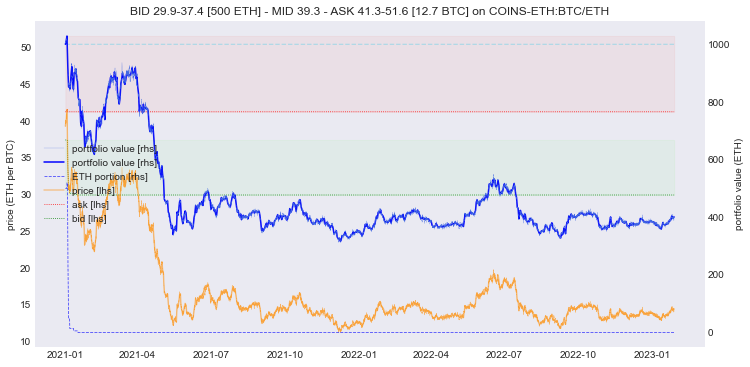


[wide1] TVL0=1000.0, TVL1_hf=413.5 (-58.7%; h=-31.6%) TVL1_lf=413.4 (-58.7%; h=-31.6%)


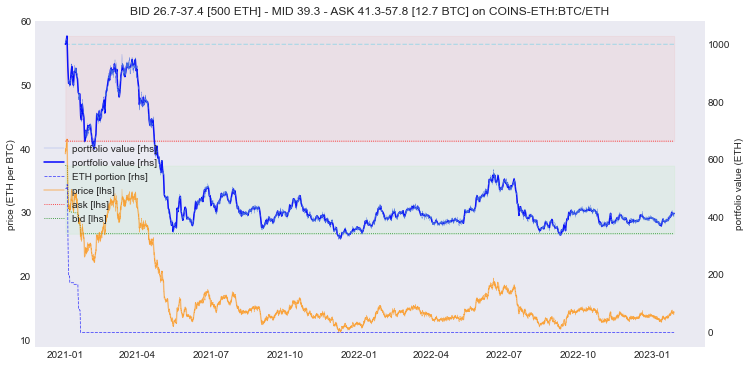


[wide2] TVL0=1000.0, TVL1_hf=415.0 (-58.5%; h=-31.6%) TVL1_lf=415.0 (-58.5%; h=-31.6%)


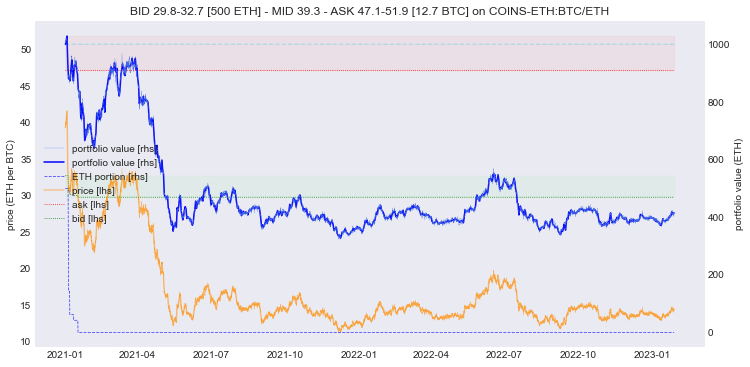


[mid1] TVL0=1000.0, TVL1_hf=395.8 (-60.4%; h=-31.6%) TVL1_lf=395.8 (-60.4%; h=-31.6%)


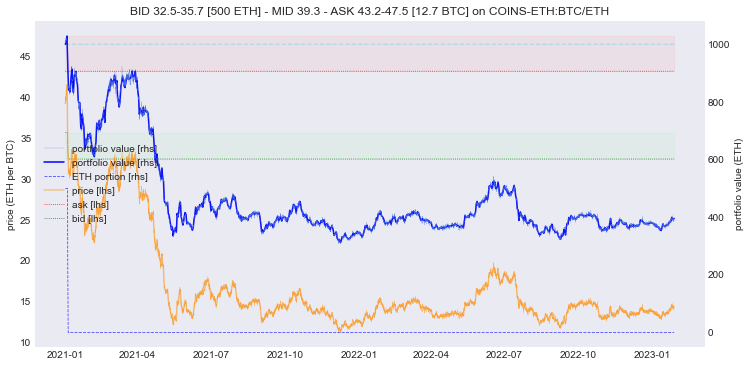


[mid2] TVL0=1000.0, TVL1_hf=396.1 (-60.4%; h=-31.6%) TVL1_lf=396.1 (-60.4%; h=-31.6%)


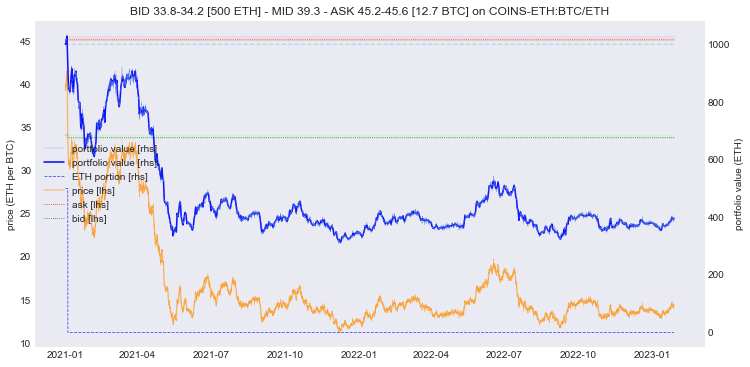


[narrow] TVL0=1000.0, TVL1_hf=384.3 (-61.6%; h=-31.6%) TVL1_lf=384.3 (-61.6%; h=-31.6%)


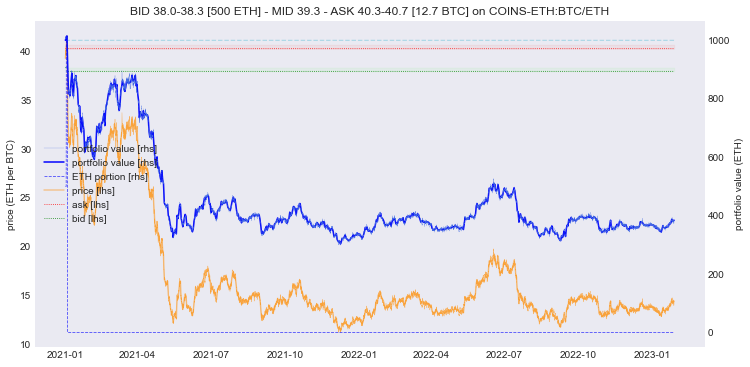

In [74]:
_ = plt_style(*plt_styles[1]) if params_w.values_dct["plotDark"] else plt_style(*plt_styles[0])
DATAID, DATAFN = datafn_w.value, j(DATAPATH, f"{datafn_w.value}.pickle") 
STARTPC, LENPC, SV, COLNM = segment_w.values[0], segment_w.values[1], strat1_w.values, datacols_w.value
path0, pair = pdread(DATAFN, COLNM, from_pc=STARTPC, period_pc=LENPC, min_dt=PATH_MIN_DATE, invert=pathops_w.values[0], tkns=True)
path = PI.interpolate(path0, PIPERIOD, sigfctr=PIFACTOR, enable=pathops_w.values[1])
path0 = path if pathops_w.values[2] else path0
strats["slider"] = [strategy.from_mgw(m=100*SV[0], g=SV[1], w=(SV[3], SV[2]), u=(SV[5], SV[4]))]
for ix, stratid in enumerate(strats_w.checked):
    strat = [s.set_tvl(spot=path0[0], cashpc=stratall_w.values[0], tvl=TVL) for s in strats[stratid]]
    simresults  = run_sim(strat, path, shift=stratall_w.values[1])
    simresults0 = run_sim(strat, path0, shift=stratall_w.values[1]) if not path is path0 else simresults
    v0, v1, v1a,  = simresults.value_r[0], simresults.value_r[-1], simresults0.value_r[-1]
    vh1, vh1a = simresults.hodl_r[-1], simresults0.hodl_r[-1]
    print(f"\n[{stratid}] TVL0={v0:.1f}, TVL1_hf={v1:.1f} ({v1/v0*100-100:.1f}%; h={vh1/v0*100-100:.1f}%) TVL1_lf={v1a:.1f} ({v1a/v0*100-100:.1f}%; h={vh1a/v0*100-100:.1f}%)")
    plot_sim(simresults, simresults0, f"{DATAID}:{COLNM}", Params(**params_w.values_dct), pair=pair, colors=colors)
    if isinstance(OUTPATH, str):
        plt.savefig(j(OUTPATH, fname(DATAID, COLNM)))
        fsave(pickle.dumps((simresults, simresults0)), f"{fname(DATAID, COLNM)}.data", OUTDATAPATH, binary=True)
    plt.show()

### Directory listing

Below are all the files that have been generated, provided you (a) chose to generated them, and (b) you chose to display them using the checkboxes above. **Remember to download the charts from `outimg` and, is so desired, the data from `outdata`** as it may be discarded at the end of the session.

In [75]:
if OUTPATH and output_w.values[1]:
    print("Listing OUTPATH [uncheck box at top to disable]")
    print ("\n".join([fn[:-4] for fn in os.listdir(OUTPATH) if fn[-4:]==".png"]))

Listing OUTPATH [uncheck box at top to disable]
0201-004112-COINS-ETH-BTCETH
0201-003533-COINS-ETH-BTCETH
0201-004033-COINS-ETH-BTCETH
0201-003456-COINS-ETH-BTCETH
0201-084500-COINS-ETH-BTCETH
0201-004319-COINS-ETH-BTCETH
0201-165528-COINS-CROSS-ETHLTC
0201-004045-COINS-ETH-BTCETH
0201-163435-COINS-CROSS-ETHLTC
0201-170300-COINS-ETH-BTCETH
0201-004004-COINS-ETH-BTCETH
0201-003944-COINS-ETH-BTCETH
0201-004016-COINS-ETH-BTCETH
0201-170312-COINS-ETH-BTCETH
0201-170158-COINS-ETH-BTCETH
0201-162637-SELECTION-NMRUSD
0201-162559-SELECTION-NMRUSD
0201-163436-COINS-CROSS-ETHLTC
0201-162600-SELECTION-NMRUSD
0201-154841-SELECTION-BNTLINK
0201-084339-COINS-ETH-BTCETH
0201-084340-COINS-ETH-BTCETH
0201-162638-SELECTION-NMRUSD
0201-170201-COINS-ETH-BTCETH
0201-165526-COINS-CROSS-ETHLTC
0201-163354-COINS-CROSS-ETHLTC
0201-170204-COINS-ETH-BTCETH
0201-084345-COINS-ETH-BTCETH
0201-170325-COINS-ETH-BTCETH
0201-170345-COINS-ETH-BTCETH
0201-163355-COINS-CROSS-ETHLTC
0201-162624-SELECTION-NMRUSD
0201-165527

### Create zip and docx

Provide the corresponding box above (_"Generate docx & zip from charts"_) is checked, this will create a Word `docx` file embedding all the `png` files _(this does not work in the JupyterLite distribution)_.

In [76]:
# if OUTPATH and output_w.values[2]:
#     print("Creating consolidated docx and zip from charts and data [uncheck box at top to disable]")
#     markdown = "\n\n".join(f"![]({OUTPATH}/{fn})" for fn in [fn for fn in os.listdir(OUTPATH) if fn[-4:]==".png"])
#     !zip _CHARTS.zip -qq *.png
#     !zip _DATA.zip -qq *.data 
#     fsave(markdown, "_CHARTS.md", OUTPATH, quiet=True)
#     !pandoc {OUTPATH}/_CHARTS.md -o {OUTPATH}/_CHARTS.docx